# Data Checks

Quick overview of data checks and explorations for a session of XX data.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from convnwb.io import load_nwbfile

from spiketools.measures.spikes import compute_firing_rate
from spiketools.plts.spatial import plot_position_by_time, plot_position_1d, plot_positions, plot_heatmap
from spiketools.plts.spikes import plot_firing_rates
from spiketools.plts.trials import plot_rasters
from spiketools.plts.data import plot_bar, plot_hist, plot_lines
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import add_hlines, add_vlines

from spiketools.utils.timestamps import convert_sec_to_min, sum_time_ranges
from spiketools.utils.extract import get_range, get_value_by_time, get_values_by_time_range, drop_range
from spiketools.utils.epoch import epoch_data_by_range
from spiketools.utils.data import compute_range
from spiketools.utils.base import count_elements

from spiketools.utils.timestamps import convert_sec_to_min
from spiketools.spatial.occupancy import compute_occupancy

In [3]:
# Local imports
import sys
sys.path.append('../code')
from plts import plot_task_structure
from utils import group_array_by_key

## Settings

In [4]:
# Define the base data folder
data_folder = '/Users/weijiazhang/Data/Train_NWB'
# Define subject information
session = {
    'experiment' : 'TRAIN',
    'subject' : 'UT048',
    'session' : 0    
}

In [5]:
# Define any quality measures
empty_time_bin = 0.25

# Define bins to use 
bins =  21

# Define occupancy related settings
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25
uind= 0

## Load Data

In [6]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

In [7]:
# Check the NWBfile contents
nwbfile

root pynwb.file.NWBFile at 0x6408304720
Fields:
  acquisition: {
    boundaries <class 'pynwb.behavior.Position'>,
    position <class 'pynwb.behavior.Position'>
  }
  data_collection: unknown
  devices: {
    Microwire Electrodes <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    BF electrode <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Task: TRAIN (english)
  experimenter: [b'Qasim, Salman' b'Jacobs, Joshua']
  file_create_date: [datetime.datetime(2023, 4, 19, 23, 17, 9, 417483, tzinfo=tzoffset(None, -14400))]
  identifier: XX
  institution: Columbia University
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  keywords: <HDF5 dataset "keywords": shape (3,), type "|O">
  lab: Electrophysiology, Memory, and Navigation Laboratory
  notes: The exact subtracted timestamp is: 151.05733129882813
  processing: {
    position_measures <class 'pynwb.base.ProcessingModule'>
  }
 

## Task Structure
In the following, lines and colors means shadings are:

- trial start: red line 
- trial end: black line (in some trials, black line can be trial start and trial end) 
- response time: grey line
- hold period: green 
- movement period: orange 
- fixation period: purple 
- feed back period: blue 


In [8]:
# Get the number of trials 
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 64


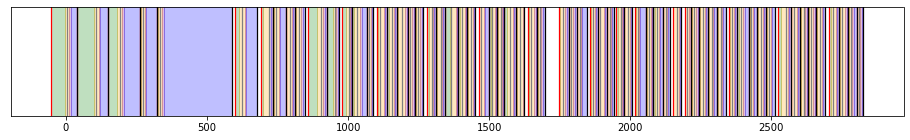

In [9]:
# Plot the task structure for the whole recording 
plot_task_structure(nwbfile.trials)

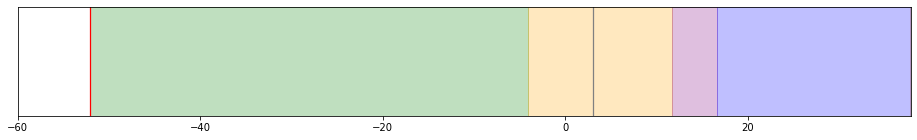

In [10]:
# Plot the task structure for 1 trial
plot_task_structure(nwbfile.trials, xlim=[-60, nwbfile.trials.stop_time[0]])

### check task time range

In [11]:
# Set start and stop time of the task (note that 0 is task start time)
task_range = [nwbfile.trials.start_time[0], nwbfile.trials.stop_time[-1]]

# Compute the task length, in minutes
task_len = convert_sec_to_min(task_range[1])

# Check the task / recording length, based on unit time
print('Task length: {:1.2f} minutes'.format(task_len))


Task length: 47.07 minutes


In [12]:
task_range

[-52.039865234375, 2824.1998752441405]

## General Checks

### Position Data Checks

In [13]:
# Grab the position data
pos = nwbfile.acquisition['position']['player_position']



In [14]:
ptimes = pos.timestamps[:]
positions = pos.data[:]
ptimes

array([0.00000000e+00, 9.99941406e-02, 1.99988037e-01, ...,
       2.81373051e+03, 2.81383050e+03, 2.81393049e+03])

array([0.00000000e+00, 9.99941406e-02, 1.99988037e-01, ...,
       2.81373051e+03, 2.81383050e+03, 2.81393049e+03])

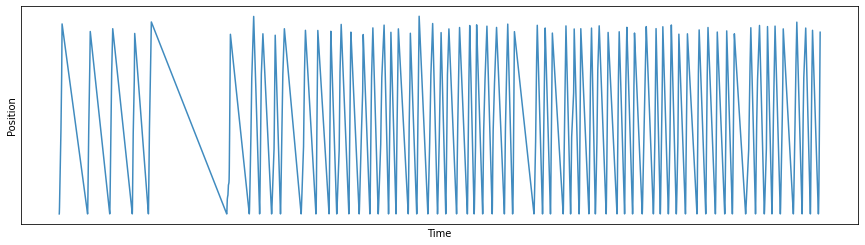

In [15]:
# Plot position across time
plot_position_by_time(pos.timestamps[:], pos.data[:], alpha=0.85, figsize=(15, 4))
ptimes

In [16]:
# Get boundary ranges 
pos_trial_range = nwbfile.acquisition['boundaries']['track_range'].data[:]
pos_trial_center =nwbfile.acquisition['boundaries']['track_center'].data[:]

# Check position ranges & compare to boundaries
print('Trial position range : \t{:6.2f} - {:6.2f}'.format(*pos_trial_range))
print('Trial center:   {:1.2f} '.format(*pos_trial_center))

Trial position range : 	-34.00 -  34.00
Trial center:   0.00 


### Check speed

Text(0, 0.5, 'frequency')

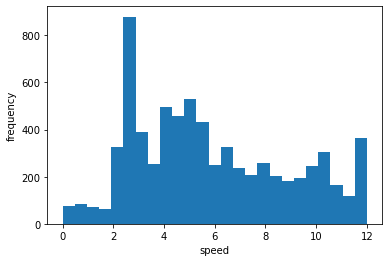

In [17]:
speed = nwbfile.processing['position_measures']['speed'].data[:]
# Plot the histogram of speed values
plot_hist(speed, bins=25)
plt.xlabel('speed')
plt.ylabel('frequency')

Text(0, 0.5, 'speed')

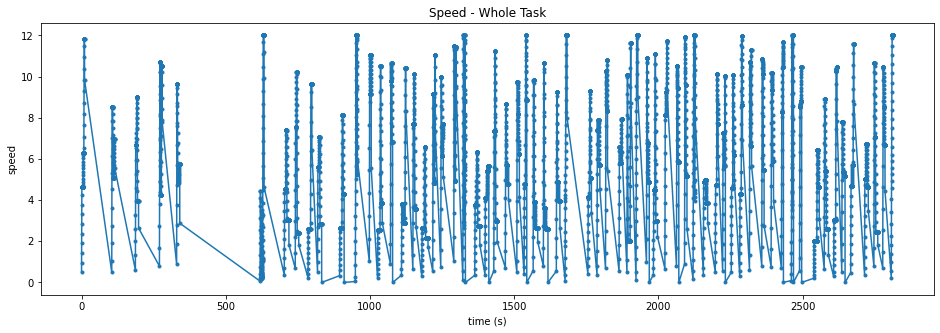

In [18]:
# Plot the speed across the whole task
plot_lines(ptimes, speed, marker='.', title='Speed - Whole Task', figsize=(16, 5))
plt.xlabel('time (s)')
plt.ylabel('speed')
#add_hlines(speed_thresh, color='red', alpha=0.75, linestyle='--')


Text(0, 0.5, 'speed')

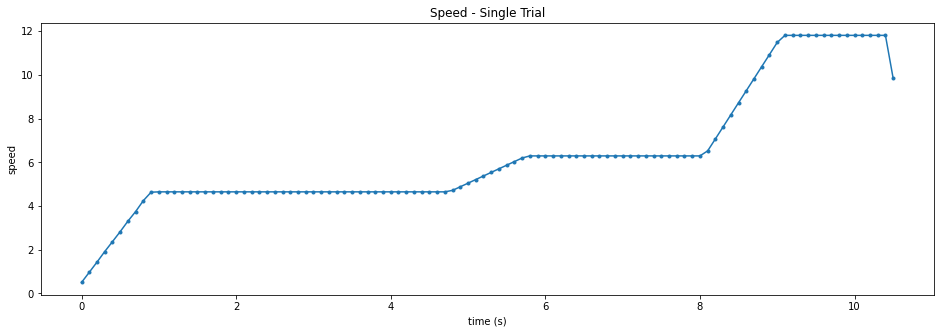

In [19]:
# Extract speed across a single navigation period (trial)
t_ind = 0
t_times, t_speed = get_values_by_time_range(
    ptimes, speed, nwbfile.trials.start_time[t_ind], nwbfile.trials.stop_time[t_ind])

# Plot the speed across a single navigation session (one trial)
plot_lines(t_times, t_speed, marker='.', title='Speed - Single Trial', figsize=(16, 5))
plt.xlabel('time (s)')
plt.ylabel('speed')
#add_hlines(speed_thresh, color='red', alpha=0.75, linestyle='--')

In [20]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

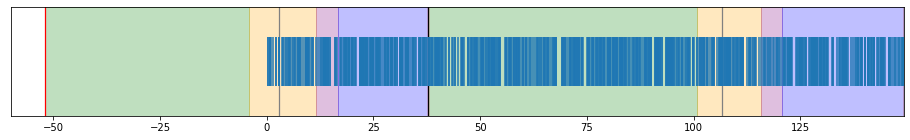

In [21]:
# Check when position times are samples across a single trial
plot_task_structure(nwbfile.trials,
                    data_points=get_range(spikes,nwbfile.trials.movement_start_time[0], nwbfile.trials.stop_time[1]),
                    xlim=[-60, nwbfile.trials.stop_time[1]])

### Check for Occupancy 

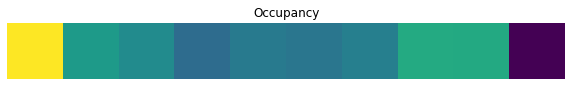

In [22]:
# Collect settings for occupancy
# TODO: add speed threshold 
time_thresh = 0.1
min_occ = 0
occ_kwargs = {'time_threshold' : time_thresh, 'minimum' : min_occ,
              'normalize' : True, 'set_nan' : True}

# Compute occupancy values
occ = compute_occupancy(positions, ptimes, bins = [10],**occ_kwargs)

# Plot the occupancy
plot_heatmap(occ, title="Occupancy", figsize=(10, 5))

In [23]:
# time_thresh: maximum time duration for sample to be included 
# default to be 250ms if the position sample larger than 250ms the gap get dropped. 
# assigning position/spike to time 

# speed_thresh: drop the position when the speed is below certain number 
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x6408586528
Fields:
  colnames: ['start_time' 'stop_time' 'drive_type' 'feedback_start_time'
 'feedback_stop_time' 'fixation_start_time' 'fixation_stop_time'
 'hold_start_time' 'hold_stop_time' 'movement_start_time'
 'movement_stop_time' 'object' 'object_position' 'response_error'
 'response_position' 'response_time' 'trial_type']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    drive_type <class 'hdmf.common.table.VectorData'>,
    feedback_start_time <class 'hdmf.common.table.VectorData'>,
    feedback_stop_time <class 'hdmf.common.table.VectorData'>,
    fixation_start_time <class 'hdmf.common.table.VectorData'>,
    fixation_stop_time <class 'hdmf.common.table.VectorData'>,
    hold_start_time <class 'hdmf.common.table.VectorData'>,
    hold_stop_time <class 'hdmf.common.table.VectorData'>,
    movement_start_time <class 'hdmf.common.table.VectorData'>,
    movement_sto

### Check for object locations 

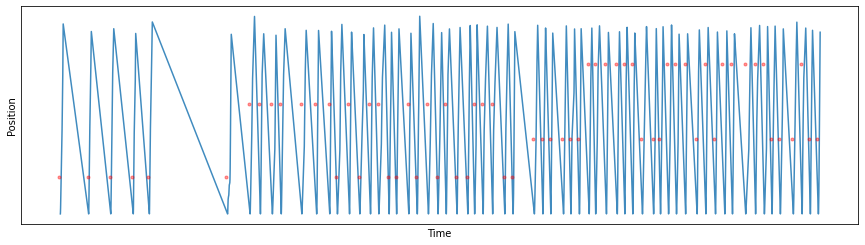

In [24]:
# Collect chest positions
obj_pos = nwbfile.trials['object_position'].data[:]
obj_times = nwbfile.trials['movement_start_time'].data[:]
obj = nwbfile.trials['object'].data[:]
# Plot the subject positions, overlaid with chest positions

# Plot position across time
plot_position_by_time(pos.timestamps[:], pos.data[:],obj_times,obj_pos,alpha=0.85, figsize=(15, 4))
#plt.scatter(obj_times, obj_pos, marker='.', color='green')



Text(0.5, 1.0, 'object positions')

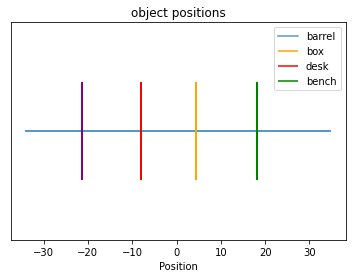

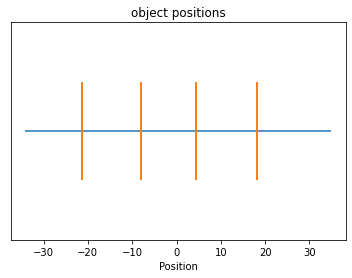

In [25]:
obj_res = group_array_by_key(obj, obj_pos)
barrel = np.array(obj_res [b'barrel'][:])
box = np.array(obj_res [b'box'][:])
desk = np.array(obj_res [b'desk'][:])
bench = np.array(obj_res [b'bench'][:])
plot_position_1d(positions, [barrel,box,desk,bench], colors = ['orange','red','green','purple'])
plt.title('object positions')
plt.legend(['barrel','box','desk','bench'])

plot_position_1d(positions, obj_pos)
plt.title('object positions')
#plt.ylabel('speed')

### Check for response locations 

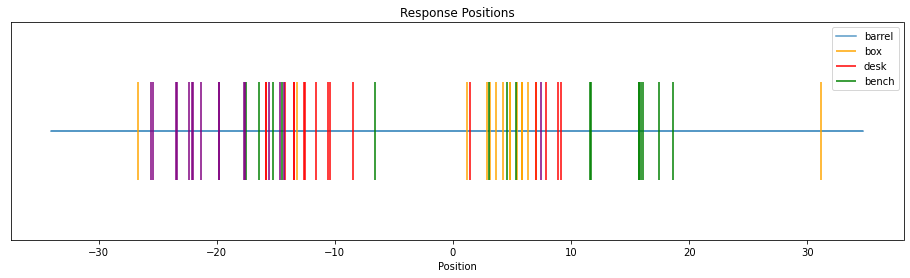

In [26]:
res_pos = nwbfile.trials['response_position'].data[:]
result_res = group_array_by_key(obj, res_pos)
barrel = np.array(result_res [b'barrel'][:])
box = np.array(result_res [b'box'][:])
desk = np.array(result_res [b'desk'][:])
bench = np.array(result_res [b'bench'][:])
plot_position_1d(positions, [barrel, box, desk, bench],
                 title='Response Positions', legend=['barrel','box','desk','bench'],
                 colors = ['orange','red','green','purple'], figsize=(16, 4))

### Check Events

In [27]:
# Check the trials data
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x6408586528
Fields:
  colnames: ['start_time' 'stop_time' 'drive_type' 'feedback_start_time'
 'feedback_stop_time' 'fixation_start_time' 'fixation_stop_time'
 'hold_start_time' 'hold_stop_time' 'movement_start_time'
 'movement_stop_time' 'object' 'object_position' 'response_error'
 'response_position' 'response_time' 'trial_type']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    drive_type <class 'hdmf.common.table.VectorData'>,
    feedback_start_time <class 'hdmf.common.table.VectorData'>,
    feedback_stop_time <class 'hdmf.common.table.VectorData'>,
    fixation_start_time <class 'hdmf.common.table.VectorData'>,
    fixation_stop_time <class 'hdmf.common.table.VectorData'>,
    hold_start_time <class 'hdmf.common.table.VectorData'>,
    hold_stop_time <class 'hdmf.common.table.VectorData'>,
    movement_start_time <class 'hdmf.common.table.VectorData'>,
    movement_sto

In [28]:
# Check the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {:d}'.format(n_trials))

Number of trials: 64


In [29]:
# Get the trial information as a dataframe
behav = nwbfile.trials.to_dataframe()
behav.head()


,start_time,stop_time,drive_type,feedback_start_time,feedback_stop_time,fixation_start_time,fixation_stop_time,hold_start_time,hold_stop_time,movement_start_time,movement_stop_time,object,object_position,response_error,response_position,response_time,trial_type
id,,,,,,,,,,,,,,,,,
0,-52.039865,37.804723,b'automatic',16.642998,37.804723,11.642998,16.642998,-52.039865,-4.100753,-4.100753,11.642998,b'bench',-21.2818,1.0703,-22.3521,2.967821,b'first'
1,37.804723,149.187013,b'automatic',120.821722,149.187013,115.821722,120.821722,37.804723,100.776929,100.776929,115.821722,b'bench',-21.2818,2.1727,-23.4545,106.580580,b'repeat'
2,149.187013,261.783231,b'automatic',203.890718,261.783231,198.890718,203.890718,149.187013,182.604000,182.604000,198.890718,b'bench',-21.2818,6.9815,-14.3003,190.116548,b'repeat'
3,261.783231,322.941547,b'automatic',285.191821,322.941547,280.191821,285.191821,261.783231,266.046974,266.046974,280.191821,b'bench',-21.2818,1.4401,-19.8417,271.928620,b'repeat'
4,322.941547,587.708598,b'automatic',346.666117,587.708598,341.666117,346.666117,322.941547,325.604386,325.604386,341.666117,b'bench',-21.2818,3.7134,-17.5684,331.868009,b'repeat'


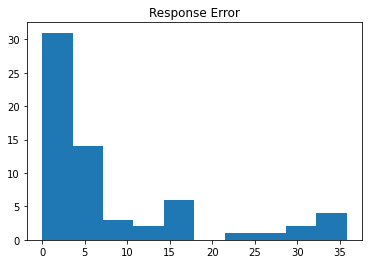

In [30]:
# plot response error
plot_hist(nwbfile.trials['response_error'].data[:], title='Response Error')

### Check Unit Data

In [31]:
# Check the units data
nwbfile.units

units pynwb.misc.Units at 0x6408587776
Fields:
  colnames: ['channel' 'spike_times' 'electrodes']
  columns: (
    channel <class 'hdmf.common.table.VectorData'>,
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    electrodes_index <class 'hdmf.common.table.VectorIndex'>,
    electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  )
  description: Spike sorting solutions - done with XX by XX.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

In [32]:
# Check how many units are available
n_units = len(nwbfile.units)
print('Number of unit: {}'.format(n_units))

Number of unit: 15


In [33]:
# Check the total number of spikes
print('Total number of spikes: {}'.format(nwbfile.units.spike_times.shape[0]))

Total number of spikes: 284281


In [34]:
# Get spiking activity from across all units
all_spikes = [nwbfile.units.get_unit_spike_times(uind) for uind in range(n_units)]

In [35]:
# Calculate the average overall firing rate of each neuron
rates = [compute_firing_rate(spikes) for spikes in all_spikes]

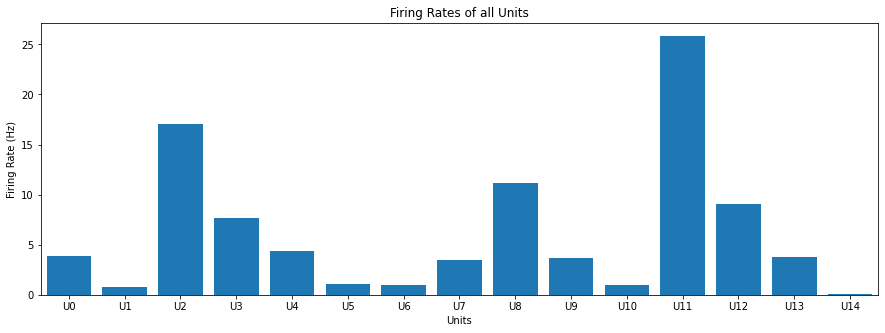

In [36]:
# Plot approximate firing rate for each unit
plot_firing_rates(rates, figsize=(15, 5))

In [37]:
# Set start and stop time of the task (note that 0 is task start time)
st = nwbfile.trials.start_time[0]
en = nwbfile.trials.stop_time[-1]

In [38]:
# Compute the task length, in minutes
task_len = convert_sec_to_min(en)

In [39]:
# Check the task / recording length, based on unit time
print('Task length: {:1.2f} minutes'.format(task_len))

Task length: 47.07 minutes


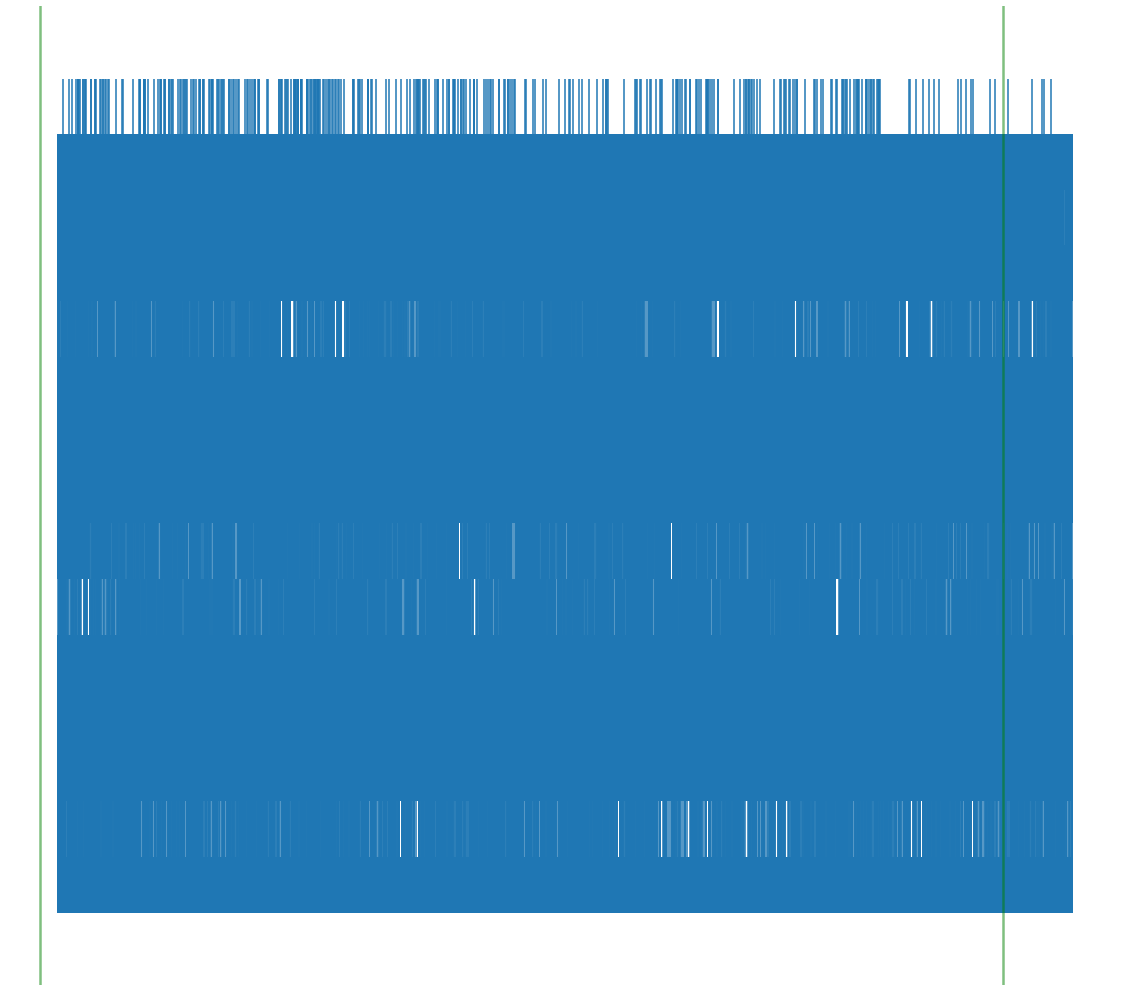

In [40]:
# Plot the session-level raster plot across all units together
plot_rasters(all_spikes, vline=[st, en], figsize=(20, 18))

## Descriptive Explorations
- explore some descriptive measures of spiking activity
- the spike times in this file are stored in milliseconds

### Spikes times

In [41]:

# Set index to access a unit of interest
s_ind = 0

# Extract spikes for the unit of interest
spikes = nwbfile.units.get_unit_spike_times(s_ind)

# Check an example selection of spike times
spikes[0:10]


array([0.22556667, 0.38163334, 0.68346667, 0.69346667, 0.71473334,
       0.78213334, 1.05613334, 1.48286668, 2.18536669, 2.21200002])

### inter-spike interval
- Look at the time interval between each spike (aka the interspike interval)
- By computing the inter-spike interval between all spikes, we can examine the distribution of interspike intervals. This gives us someinformation about the patterns of unit firing

/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_33257/2562527553.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(isi)


Text(0, 0.5, 'density')

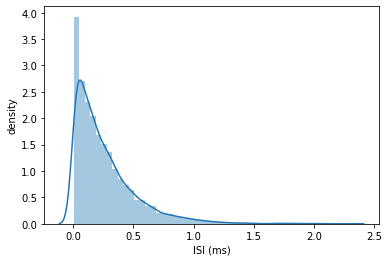

In [46]:
# Compute ISI for a single neuron
isi = np.diff(np.array(spikes))

# Plot the inter-spike intervals
sns.distplot(isi)
plt.xlabel('ISI (ms)')
plt.ylabel('density')

### Coefficient of Variation 
- From the ISI distribution, you can compute the coefficient of variation. 
- Note that the CV does not vapture potential variability on longer time scales especially if there's drifit in the neurons mean firing rate over time. 
- Bursty neuron: a neuron that tends to fire a lot of action potentials in short bursts, rather than as isolated single spikes
    - tend to violate Poisson assumption 
    - have ISI distributions that look a little more bimodal, with lots of spikes close together, and lots of bursts far apart

In [47]:
# Compute coefficient of variation
cv = np.std(isi) / np.mean(isi)
# Check the computed CV
print(cv)

0.9932941422554445
